In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import numpy as np
import io
import re
import string
import tqdm
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import contractions

import matplotlib.pyplot as plt

import nlpaug.augmenter.word as naw
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

2022-11-11 14:05:56.773229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 14:05:56.773245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-11 14:05:58.761048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 14:05:58.761428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 14:05:58.761495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

### We are using dataset from https://data.world/crowdflower/sentiment-analysis-in-text

In [3]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./data/text_emotion.csv")

In [4]:
cleaned_df = df.copy()
# lowercasing 'content' column
cleaned_df['content'] = cleaned_df['content'].str.lower()

# expanding contractions
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: contractions.fix(sentence))

# remove anything http
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('.*http.*','',word) for word in sentence.split()]))

# removing all words with #hastag and @name and urls
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('@.*','',word) for word in sentence.split()]))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('#.*','',word) for word in sentence.split()]))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('.*www\..*','',word) for word in sentence.split()]))

# removing words with digits like game57
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: re.sub('\w*\d+\w*','',sentence))

# removing all punctuation marks
exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: regex.sub("",sentence))

# removing unicode characters
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: sentence.encode("ascii","ignore").decode())

# removing stopwords
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([word for word in sentence.split() if word not in stop_words]))

# lemmatization
lemmatizer = WordNetLemmatizer()
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([lemmatizer.lemmatize(word) for word in sentence.split()]))

# remove empty sentences
cleaned_df= cleaned_df[cleaned_df['content'] != '']

# dropping unecessary columns
cleaned_df = cleaned_df.drop(columns=['tweet_id','author']).sample(frac=1).reset_index(drop=True)

# Using word2vec skip-gram algorithm to get non-contextual word vectors

### Finding the length of the maximum sentence, and vocab size in the dataset

In [5]:
max_length = cleaned_df['content'].apply(lambda s: len(s.split())).max()
no_of_words = cleaned_df['content'].apply(lambda content: len(content.split())).sum()


# count vocab size
cache=set()

#counting padding and [unkownd] token
vocab_size= 1
for key,sentence in cleaned_df['content'].items():
    words = sentence.split()
    for word in words:
        if(word not in cache):
            vocab_size+=1
            cache.add(word)
            
print("max sentence length of 'content' is {}".format(max_length))
print("total number of words of content is {}".format(no_of_words))
print("total number of unique words/vocab_size of content is {}".format(vocab_size))

max sentence length of 'content' is 25
total number of words of content is 269556
total number of unique words/vocab_size of content is 31045


### function to generate training data

In [6]:
def generate_training_data(sequences, window_size,num_ns,vocab_size,seed):
    
    # each training sentence is appended to these list
    targets,contexts,labels = [],[],[]
    
    # sampling table for vocab_size tokens
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # iterate over all sentences in dataset
    for sequence in tqdm.tqdm(sequences):
       

        # generating positive skip-gram pairs for a sequence
        positive_skip_grams,_ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size = vocab_size,
            sampling_table=sampling_table,
            window_size=window_size, # TODO: change window size
            negative_samples=0
        )
        
        # produce negative samples and create training samples (x_train,labels)
        for target_word, context_word in positive_skip_grams:
    
    
            # expand context word to frmo dim shape (1,0) to (1,1)
            context_class = tf.expand_dims(
                tf.constant([context_word],dtype='int64'),1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class, # to tell the which sample is positive
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size, #TODO: may need to change to just the negative samples of the sentence itself instead of the entire vocab
                seed=seed,
                name='negative_sampling')
    
    
            # building the context and label vectors for a target word
            context = tf.concat([tf.squeeze(context_class,1),negative_sampling_candidates],0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")
    
    
            # append each element from the training ex to global lists
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
    
    return targets, contexts, labels 
            
            

### Vectorizing all vocab found in cleaned_df

In [7]:
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=int(max_length))

2022-11-11 14:06:03.324467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### replace vocab with their respective tokens:

In [8]:
BATCH_SIZE = 64

In [9]:
# creating a dataset of all sentences
text_ds = tf.data.Dataset.from_tensor_slices(cleaned_df['content'])
vectorize_layer.adapt(text_ds.batch(BATCH_SIZE))

### build a inverse vocab which maps indexes -> words which can be handy

In [ ]:
inverse_vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Vectorize the data in text_ds.
# prefetch does fetching of data and training at the same time using multiple thread
# improving performance
text_vector_ds = text_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

### As you can see we have successfully vectorised our sentences/sequences

In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

## Using unsupervised learning (word2Vec skip_gram) to predict context from targets. 
>While doing so, we are also training the weights on the embeddings. We can increase window size so that the embeddings learn more contextutal knowledge with respect to the words around them

In [ ]:
# to determine window size, we see the median length of a sentence

print(cleaned_df['content'].apply(lambda s: len(s.split())).median())
print(cleaned_df['content'].apply(lambda s: len(s.split())).mean())

### We go with window size of 2 since that the median length of a sentence is 6. we want to offer 4 slots some space for negative sampling

In [ ]:
# note higher window size is more computationally expensive
# from documentation, it is said that for small datasets, negative samples of range 5to 20 yields the best results

WINDOW_SIZE = 2
num_ns = 4

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=WINDOW_SIZE,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

### Configuring training sets for Word2Vec model

In [ ]:
# batching the dataset
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

In [ ]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
              embedding_dim,
              input_length=1,
              name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
               embedding_dim,
               input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        return dots

In [ ]:
# embedding size for a word is chosen to be 50

EMBEDDING_DIM = 50

word2vec = Word2Vec(vocab_size, EMBEDDING_DIM)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
# call back to log training stats for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
history = word2vec.fit(dataset, epochs=15, callbacks=[tensorboard_callback])

In [ ]:
import matplotlib.pyplot as plt
y = history.history['loss']
x = [i+1 for i in range(0,len(y))]
plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')

### Writing vectors to file

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
out_v = io.open('./data/custom_vectors.tsv', 'w')
out_m = io.open('./data/custom_metadata.tsv', 'w')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

### Reading vectors from Custom w2v:

In [10]:
def read_custom_tsv(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
        result.append([float(value) for value in line.split()])
        
    file.close()
    return result

In [11]:
def read_custom_meta(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
            
        result.append(line.strip())
    file.close()
    return result

In [12]:
vectors = read_custom_tsv('./data/custom_vectors.tsv')
classes = read_custom_meta('./data/custom_metadata.tsv')

In [13]:
# make an inverse index of the classes name -> index
word_vector_map = {}
for index,word in enumerate(classes):
    word_vector_map[word] = vectors[index]

### Now we are done with getting the vectors for embedding layer ...
---

# Visualising the data

### Distribution of lengths of sentences

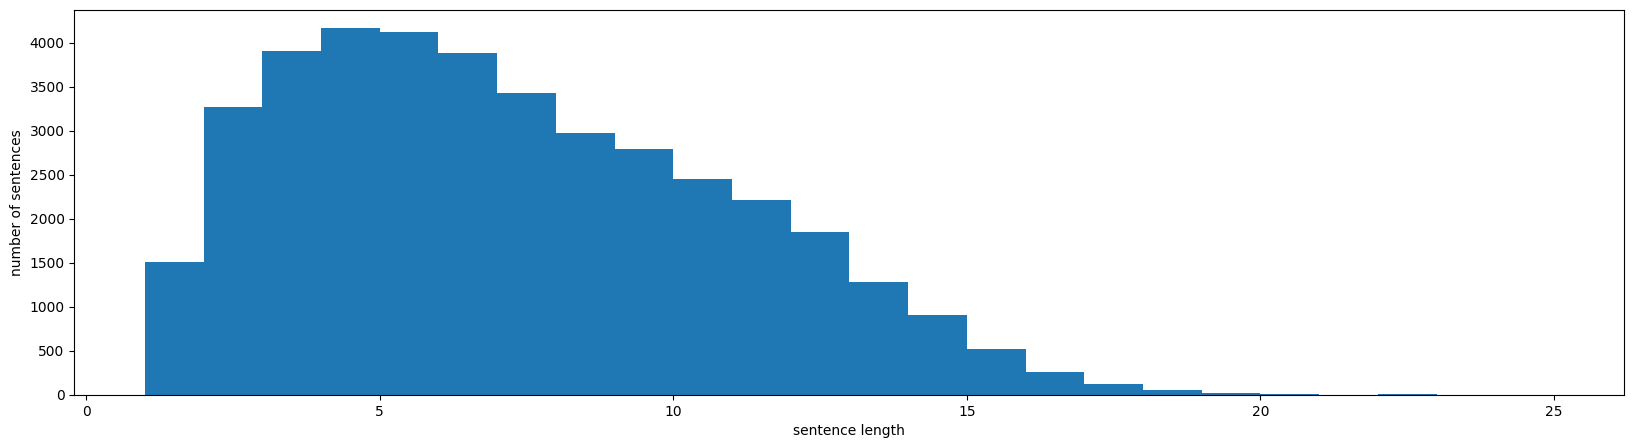

In [14]:
lengths = [len(sentence.split()) for sentence in cleaned_df['content']]
plt.rcParams['figure.figsize'] = [20, 5]
plt.hist(lengths,bins=len(set(lengths)))
plt.xlabel('sentence length')
plt.ylabel('number of sentences')

plt.show()

In [15]:
print('Unique labels:')
for i, label in enumerate(cleaned_df['sentiment'].unique()):
    print('{}) {}'.format(i,label)) 

Unique labels:
0) empty
1) neutral
2) worry
3) love
4) happiness
5) sadness
6) surprise
7) relief
8) hate
9) fun
10) enthusiasm
11) boredom
12) anger


### distribution of sentiments

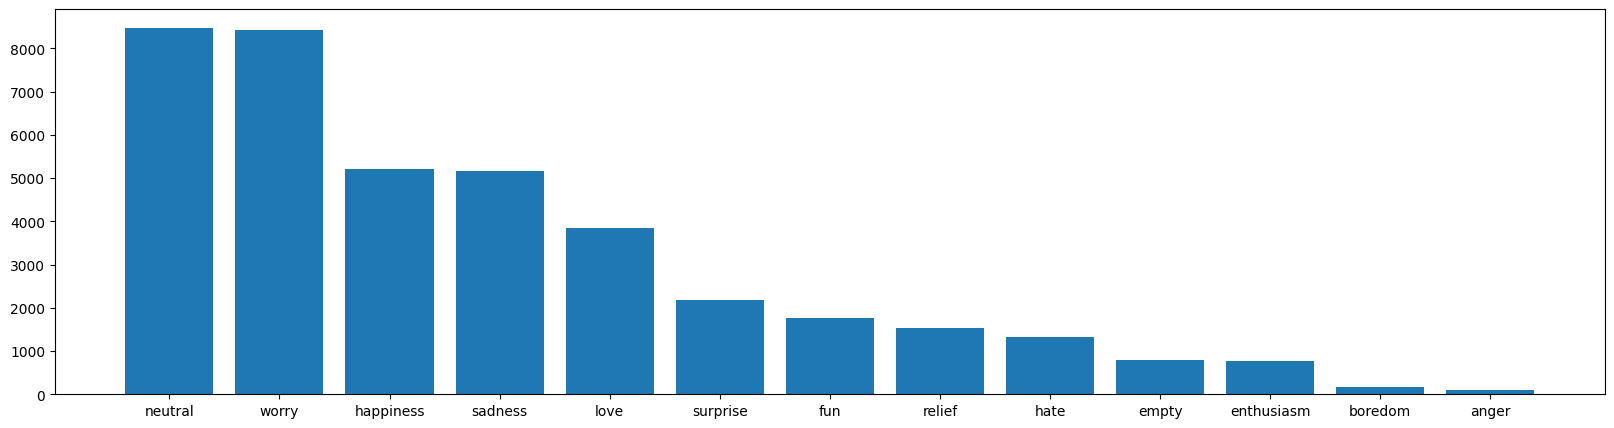

In [16]:
plt.rcParams['figure.figsize'] = [20, 5]
x= list(dict(cleaned_df.sentiment.value_counts()).keys())
y = list(cleaned_df.sentiment.value_counts())
plt.bar(x,y)
plt.show()

In [17]:
cleaned_df['sentiment'].value_counts()

neutral       8480
worry         8429
happiness     5202
sadness       5156
love          3836
surprise      2176
fun           1775
relief        1523
hate          1320
empty          801
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

## To prevent long-tailed distribution problem. we duplicate data for each underrepresented sentiments to be equals to the number of the sentiment with the most number of data

In [18]:
sentiment_count = dict(cleaned_df['sentiment'].value_counts())

# find the sentiment with the largest number of data in training setsentiment,count
max_sentiment = [0,0]
for sentiment,count in sentiment_count.items():
    if(count > max_sentiment[1]):
        max_sentiment[0] = sentiment
        max_sentiment[1] = count
print("The sentiment with the most number of data is {} with {} data".format(max_sentiment[0],max_sentiment[1]))

The sentiment with the most number of data is neutral with 8480 data


### Duplicating sentences from lesser represented sentiments

In [19]:
# We augment data until each sentiment has equal number of data as the sentiment with the largest amount of data
benchmark_count = max_sentiment[1]

# remove the sentiment with the largest amount of data as it need not be augmented
sentiments_to_augment = [sentiment for sentiment in cleaned_df['sentiment'].unique() if sentiment!= max_sentiment[0]]

augmented_df = {
    "content":[],
    "sentiment":[]
}

# duplicate data
for i in tqdm.tqdm(range(len(sentiments_to_augment))):
    sentiment = sentiments_to_augment[i]
    current_no = sentiment_count[sentiment]
    augment_no = benchmark_count -  current_no
    data = cleaned_df[cleaned_df['sentiment'] == sentiment].reset_index(drop=True)
    for i in range(augment_no):
        content = data['content'].iloc[i % len(data)]
        augmented_df['content'].append(content)
        augmented_df['sentiment'].append(sentiment)

100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.83it/s]


In [20]:
cleaned_df = pd.concat([cleaned_df,pd.DataFrame(augmented_df)],ignore_index=True)

### As we can see the distribution in the new dataset is now even

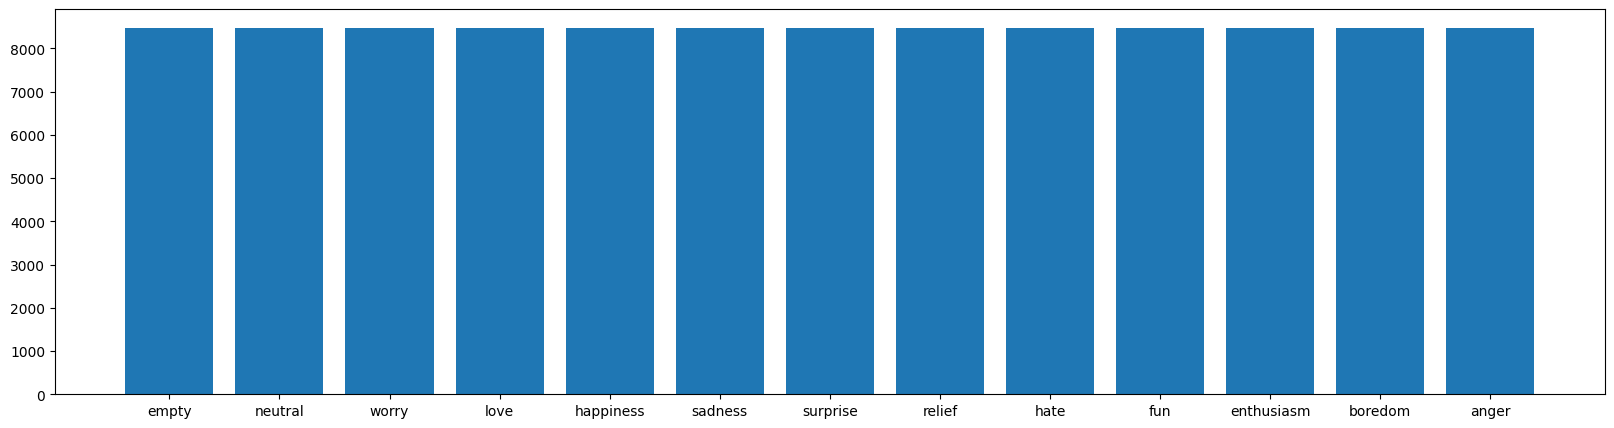

In [21]:
plt.rcParams['figure.figsize'] = [20, 5]
x= list(dict(cleaned_df.sentiment.value_counts()).keys())
y = list(cleaned_df.sentiment.value_counts())
plt.bar(x,y)
plt.show()

In [22]:
cleaned_df['sentiment'].value_counts()

empty         8480
neutral       8480
worry         8480
love          8480
happiness     8480
sadness       8480
surprise      8480
relief        8480
hate          8480
fun           8480
enthusiasm    8480
boredom       8480
anger         8480
Name: sentiment, dtype: int64

In [23]:
# shuffle data
cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)

# Converting 'content' column to sequences
---

In [24]:
# Vectir dimension is 50
EMBEDDING_DIM = 50

# get all the content lines train and test
content_lines = list(cleaned_df['content'])
tokeniser_obj = Tokenizer()
tokeniser_obj.fit_on_texts(content_lines)

word_index = tokeniser_obj.word_index
print('Found {} unique tokens'.format(len(word_index)))

sequences = tokeniser_obj.texts_to_sequences(content_lines)

# pad shorter sentence to fit max_length of sentence
content_pad = pad_sequences(sequences,maxlen = max_length)

Found 31044 unique tokens


In [25]:
# number of words has to +1 for the padding
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))

In [26]:
embedding_matrix.shape

(31045, 50)

### Map embeddings to the embedding Matrix to feed into Models

In [27]:
count_w2v = 0

for word,i in word_index.items():

    embedding_vector_w2v = word_vector_map.get(word)

    if(embedding_vector_w2v is not None):
        embedding_matrix[i] = embedding_vector_w2v
        count_w2v+=1
        continue
        
print("number of words vectorised from w2v: {}/{}".format(count_w2v,num_words))

number of words vectorised from w2v: 31043/31045


## One-hot encoding the indices

In [28]:
# map labels -> indices
sentiment_labels = cleaned_df['sentiment'].unique().copy()

# index key -> class
label_map = {}

# class -> index key
inverse_label_map = {}
for i, label in enumerate(sentiment_labels):
    label_map[i] = label 
    inverse_label_map[label] = i

In [29]:
# get all keys
indices = list(label_map.keys())
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [30]:
# maps the word to the one hot vector
depth = len(indices)
one_hot_encoding = tf.one_hot(indices,depth)

## map for indices to labels

In [31]:
word_to_vec = {}    
for i,oh in enumerate(one_hot_encoding):
    print("{} --> {}".format(oh,label_map[i]))
    word_to_vec[label_map[i]] = oh.numpy()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> boredom
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> relief
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> love
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> surprise
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] --> hate
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] --> neutral
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] --> worry
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] --> enthusiasm
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] --> fun
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] --> happiness
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] --> sadness
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] --> anger
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] --> empty


In [32]:
word_to_vec

{'boredom': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'relief': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'love': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'surprise': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'hate': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'neutral': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'worry': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'enthusiasm': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 'fun': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 'happiness': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 'sadness': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 'anger': array([0., 0., 0., 0., 0., 0.

## replacing the labels in dataset with one-hot encoding

In [33]:
# getting one-hot encoding for labels

labels=[]
for sentiment in tqdm.tqdm(cleaned_df['sentiment'].values):
    o_h = one_hot_encoding[inverse_label_map[sentiment]]
    labels.append(o_h)
labels = np.asarray(labels)

100%|█████████████████████████████████████████████████████| 110240/110240 [00:12<00:00, 8750.65it/s]


In [34]:
TRAINING_SIZE = int(len(content_pad)*0.7)

X_train_pad = content_pad[:TRAINING_SIZE]
y_train = labels[:TRAINING_SIZE]

X_test_pad = content_pad[TRAINING_SIZE:]
y_test = labels[TRAINING_SIZE:]

print("Training size: {}".format(TRAINING_SIZE))
print("Test size: {}".format(len(content_pad)-TRAINING_SIZE))


Training size: 77168
Test size: 33072


# Training and testing RNN,GRU,LSTM and Transformer models

### callback to save weights:

In [ ]:
# callback to save the best weights for the model
def saveWeightsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 2,
        save_best_only = True,
        save_weights_only = True,
        mode = mode,
        save_freq=save_freq,
)

## Building a RNN model

In [ ]:
def build_RNN_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_words,
                               embedding_dim,
                               weights=[embedding_matrix]))

    model.add(
        layers.Bidirectional(
            layers.SimpleRNN(units=64,return_sequences=True)
        ))
    model.add(layers.Dropout(0.2))
    model.add(
        layers.Bidirectional(
            layers.SimpleRNN(units=64)
        ))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    
    return model

In [ ]:
RNN_model = build_RNN_model(EMBEDDING_DIM,max_length)

RNN_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

RNN_model.summary()

In [ ]:
history = RNN_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 20,
                        verbose=1,
                        validation_data = (X_test_pad,y_test),
                        callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                                     saveWeightsCallback(
                                         path='./weights/RNN',
                                         monitor = 'val_loss',
                                         mode = 'min',
                                         save_freq='epoch')])         

## Loss over Epochs

In [ ]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

## Validation accuracy over Epochs

In [ ]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')

print('RNN validation accuracy: {}'.format(round(val_accuracy[-1],4)))

# Building GRU model

In [ ]:
def build_GRU_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_words,
                               embedding_dim,
                               weights=[embedding_matrix]))

    model.add(
        layers.Bidirectional(
            layers.GRU(units=64,return_sequences=True)
        ))
    model.add(layers.Dropout(0.2))
    model.add(
        layers.Bidirectional(
            layers.GRU(units=64)
        ))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    
    return model

In [ ]:
GRU_model = build_GRU_model(EMBEDDING_DIM,max_length)

GRU_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

GRU_model.summary()

In [ ]:
history = GRU_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 20,
                        verbose=1,
                        validation_data = (X_test_pad,y_test))

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                     saveWeightsCallback(
                         path='./weights/GRU',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],         

## Loss over Epochs

In [ ]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

## Validation accuracy over Epochs

In [ ]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
print('GRU validation accuracy: {}'.format(round(val_accuracy[-1],4)))

# LSTM

In [ ]:
def build_LSTM_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=num_words,
                               output_dim=embedding_dim))
    model.add(layers.Bidirectional(
        layers.LSTM(units=64,return_sequences=True)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(
        layers.LSTM(units=64)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    return model

In [ ]:
LSTM_model = build_LSTM_model(EMBEDDING_DIM,max_length)

LSTM_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

LSTM_model.summary()

In [ ]:
history = LSTM_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 20,
                        verbose=1,
                        validation_data = (X_test_pad,y_test),
                        callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                                     saveWeightsCallback(
                                         path='./weights/LSTM',
                                         monitor = 'val_loss',
                                         mode = 'min',
                                         save_freq='epoch')])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                     saveWeightsCallback(
                         path='./weights/LSTM',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],         

## Loss over epochs for LSTM model

In [ ]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

## Accuracy over epochs for LSTM model

In [ ]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('accuracy')
print('LSTM validation accuracy: {}'.format(round(val_accuracy[-1],4)))

# Transformers

In [35]:
import warnings 
warnings.filterwarnings('ignore')

In [36]:
df = cleaned_df.copy()

In [37]:
df.head()

,sentiment,content
0,boredom,longest flight ever particularly unpleasant uncomfortable really really long
1,relief,finally leavin tha studiomade really really good music pleased wit tha turnout
2,love,ha good love boy co never stir hatred mighty red scum everyone love city
3,boredom,bored day one talk missing bf kiss hols almost want go back skool
4,surprise,lolzz public script wait n watch


from transformers import AutoTokenizer, TFBertModel

tokenizer=AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

In [38]:
from transformers import AutoTokenizer,DistilBertTokenizer,DistilBertConfig,TFDistilBertModel
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

2022-11-11 14:06:32.453527: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

tokenizer=AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

In [39]:
df['sentiment'] = df['sentiment'].astype("category")

In [40]:
df['encoded_sentiment'] = df.sentiment.cat.codes 

In [41]:
sentiment_encoding_map = {}
inverse_sentiment_encoding_map = {}


for key,value in df['encoded_sentiment'].items():
    sentiment =df['sentiment'].iloc[key] 
    if sentiment_encoding_map.get(sentiment) == None:
        sentiment_encoding_map[sentiment] = value
        inverse_sentiment_encoding_map[value] = sentiment

In [42]:
sentiment_encoding_map

{'boredom': 1,
 'relief': 9,
 'love': 7,
 'surprise': 11,
 'hate': 6,
 'neutral': 8,
 'worry': 12,
 'enthusiasm': 3,
 'fun': 4,
 'happiness': 5,
 'sadness': 10,
 'anger': 0,
 'empty': 2}

In [43]:
df['sentiment'] = df.sentiment.cat.codes

In [44]:
TRAINING_SIZE = int(0.7 * len(df['content']))

X_train = df['content'][:TRAINING_SIZE]
y_train = df['sentiment'][:TRAINING_SIZE] 

X_test = df['content'][TRAINING_SIZE:] 
y_test = df['sentiment'][TRAINING_SIZE:] 

In [45]:
x_train = tokenizer(
    text= X_train.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

x_test = tokenizer(
    text= X_test.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)


In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense

In [65]:
input_ids = Input(shape=(max_length,),dtype=tf.int32,name="input_ids")
input_mask = Input(shape=(max_length,),dtype=tf.int32,name="attention_mask")

embeddings = bert(input_ids,attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.2)(out)
out = Dense(64,activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)
y = Dense(13,activation='sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

#enables embeddings to be trained
model.layers[2].trainable = True

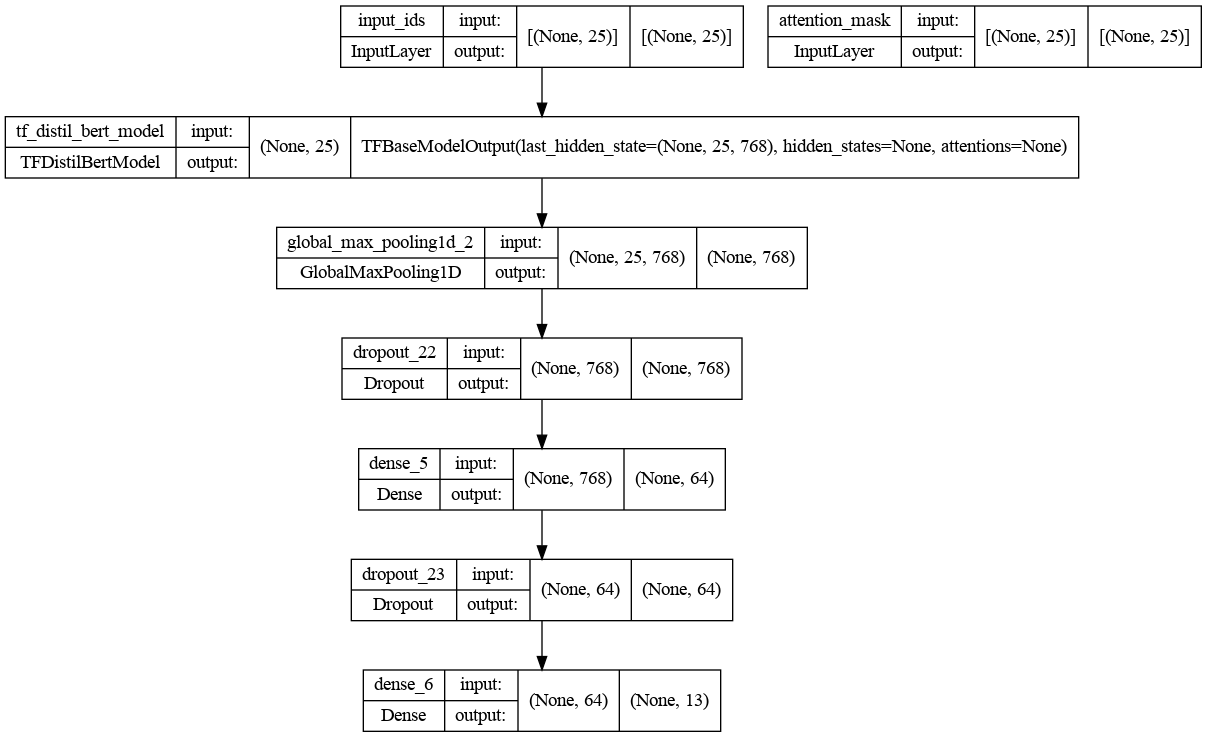

In [66]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [73]:
optimizer = Adam(
    learning_rate = 0.001,
    clipnorm=1.0
)

# set loss and metrics

loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics = metric
)

In [74]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 25)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 25)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 25, 768),                                                    
                                 hidden_states=None                                         

In [75]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

In [76]:
to_categorical(y_train)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [77]:
x_train['input_ids']

<tf.Tensor: shape=(77168, 25), dtype=int32, numpy=
array([[  101,  6493,  3462, ...,     0,     0,     0],
       [  101,  2633, 12203, ...,     0,     0,     0],
       [  101,  5292,  2204, ...,     0,     0,     0],
       ...,
       [  101,  4086,  2100, ...,     0,     0,     0],
       [  101,  5131,  4248, ...,     0,     0,     0],
       [  101,  2051,  2793, ...,     0,     0,     0]], dtype=int32)>

In [78]:
history = model.fit(
    x= {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
    y= to_categorical(y_train),
    validation_data=(
        {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},
        to_categorical(y_test)
    ),
    epochs=1,
    batch_size = BATCH_SIZE)

   5/1206 [..............................] - ETA: 59:04 - loss: 2.7115 - balanced_accuracy: 0.0688

KeyboardInterrupt: 